In [4]:
import os
import re
import copy
from pprint import pprint

LOG_DIR = f"{os.getcwd()}/../../log/end_to_end"


In [36]:
import json
from dataclasses import dataclass
import numpy as np

@dataclass
class Request:
    req_id: int
    model_name: str
    prompt_len: int
    output_len: int
    arrival_time: int
    submit_time: int
    prefill_end: int
    end: int


def extract_req_line(line: str):
    request_info = line.strip().split()
    req_id = int(request_info[request_info.index("Request") + 1])
    model_name = request_info[request_info.index("model") + 1]
    prompt_len = int(request_info[request_info.index("prompt") + 1])
    output_len = int(request_info[request_info.index("output") + 1])
    arrival_time = float(request_info[request_info.index("arrival") + 1])
    submit_time = float(request_info[request_info.index("submit") + 1])
    prefill_end = float(request_info[request_info.index("prefill_end") + 1])
    end = float(request_info[request_info.index("end") + 1])
    req = Request(req_id, model_name, prompt_len, output_len, arrival_time, submit_time, prefill_end, end)
    return req


def read_llama_json(path: str):
    res = {
        "llama-7b": {},
        "llama-13b": {},
        "llama-30b": {},
        "llama-65b": {},
    }

    with open(path, "r") as fp:
        content:dict[str,dict[int,dict]] = json.load(fp)

    for model, model_cost in content.items():
        for ngpu, ngpu_cost in model_cost.items():
            ngpu = int(ngpu)
            res[model][ngpu] = {}

            for mps, mps_cost in ngpu_cost.items():
                mps = int(mps)
                res[model][ngpu][mps] = {}
                for batch_size, bs_cost in mps_cost.items():
                    batch_size = int(batch_size)
                    res[model][ngpu][mps][batch_size] = {}
                    decoding_latencies = []
                    for seq_len, cost_info in bs_cost.items():
                        seq_len = int(seq_len)
                        prefill_cost = cost_info["prefill"]
                        decode_cost = cost_info["decoding"]
                        if prefill_cost < 0 and decode_cost < 0:
                            continue

                        res[model][ngpu][mps][batch_size][
                            seq_len] = {}
                        if prefill_cost > 0:
                            res[model][ngpu][mps][batch_size][
                                seq_len]["prefill"] = prefill_cost / 1000
                        if decode_cost > 0:
                            decoding_latencies.append(decode_cost)
                            res[model][ngpu][mps][batch_size][
                                seq_len]["decoding"] = np.mean(
                                    decoding_latencies) / 1000
    return res


def get_basline_lt(model_costs: dict)->dict[str, dict[str, dict[str, float]]]:
    res = {}
    model2ngpus = {
        "llama-7b": 1,
        "llama-13b": 1,
        "llama-30b": 4,
        "llama-65b": 8,
    }

    mps = 100
    batch = 1
    for model, cost in model_costs.items():
        ngpus=model2ngpus[model]
        res[model] = cost[ngpus][mps][batch]

    return res

# model_cost = read_llama_json("../../examples/placement/llama.json")

# pprint(get_basline_lt(model_cost))

baseline = {'llama-13b': {32: {'decoding': 0.0198, 'prefill': 0.020882},
               64: {'decoding': 0.0198015, 'prefill': 0.022158999999999998},
               128: {'decoding': 0.019932333333333333,
                     'prefill': 0.029684000000000002},
               256: {'decoding': 0.020116999999999996, 'prefill': 0.039314},
               512: {'decoding': 0.020397199999999997,
                     'prefill': 0.07577500000000001}},
 'llama-30b': {32: {'decoding': 0.025072, 'prefill': 0.036543},
               64: {'decoding': 0.0249465, 'prefill': 0.037311},
               128: {'decoding': 0.024406666666666667, 'prefill': 0.036682},
               256: {'decoding': 0.0241195, 'prefill': 0.038727},
               512: {'decoding': 0.024103199999999998, 'prefill': 0.062819}},
 'llama-65b': {32: {'decoding': 0.032904, 'prefill': 0.049544},
               64: {'decoding': 0.0318775, 'prefill': 0.049874},
               128: {'decoding': 0.031788, 'prefill': 0.05021},
               256: {'decoding': 0.031942, 'prefill': 0.054674999999999994},
               512: {'decoding': 0.031767000000000004, 'prefill': 0.077788}},
 'llama-7b': {32: {'decoding': 0.011264, 'prefill': 0.014082},
              64: {'decoding': 0.011244, 'prefill': 0.014129},
              128: {'decoding': 0.011326000000000001, 'prefill': 0.016023},
              256: {'decoding': 0.01144325, 'prefill': 0.023747},
              512: {'decoding': 0.011651400000000001, 'prefill': 0.041027}}}

def estimate_SLO(baseline: dict[str,dict], scale_lis:list[float], reqs: list[Request], modelname2type: dict[str,str]):
    '''
    {'llm-0': 'total':2000, 1: 0, 1.5: 1000, 2: 2000}
    '''
    def get_baseline(prompt_len, out_len, model_type):
        # 1. get estimation of prefill latency
        bounds = [32, 64, 128, 256, 512]
        for i, bound in enumerate(bounds):
            if prompt_len >= 512:
                prefill_lt = baseline[model_type][512]["prefill"] * (prompt_len/512)
                break
            elif bounds[i+1] >= prompt_len >= bound:
                lo = baseline[model_type][bound]["prefill"]
                hi = baseline[model_type][bounds[i+1]]["prefill"]
                prefill_lt = ((prompt_len-bound) / (bounds[i+1]-bound)) * (hi-lo)
                break
            else:
                prefill_lt = baseline[model_type][32]["prefill"]
                break

        # 2. get estimation of decode latency
        decoding_lt = sum(x["decoding"] for x in baseline[model_type].values()) / len(baseline[model_type])

        return prefill_lt + out_len * decoding_lt

    attainment = {}

    for req in reqs:
        llm_id = req.model_name

        if llm_id not in attainment:
            attainment[llm_id] = {x:0 for x in scale_lis}
            attainment[llm_id]["total"] = 0

        attainment[llm_id]["total"] += 1

        model_type = modelname2type[llm_id]
        real_lt = (req.end - req.arrival_time)
        base_lt = get_baseline(req.prompt_len, req.output_len, model_type)

        for scale in scale_lis:
            if real_lt <= base_lt*scale:
                attainment[llm_id][scale] += 1

    return attainment


def extract_from_log_file(fname: str) -> dict:
    res = {}
    with open(fname, "r") as fp:
        lines = fp.readlines()

    value = {
        "model_type": None,
        "tpt": None,
    }
    if "mesh" in fname:
        value["dev"] = fname.split("/")[-1].split(".")[0]
    else:
        for line in lines:
            if "rank_to_dev" in line:
                value["dev"] = str(line.split(":")[-1].count(",") + 1)
                break

    reqs = []
    for i, line in enumerate(lines):
        if "Finish all requests, total" in line:
            num_req = int(line.split("Finish all requests, total")[-1].strip())

            for j in range(1, num_req+1):
                req = extract_req_line(lines[i + j])
                reqs.append(req)
            # res["reqs"]=reqs


        if "] Name: " in line:
            llm_id = "llm-{}".format(int(line.split("llm-")[-1].strip()))
            res[llm_id] = copy.deepcopy(value)

            for j in range(1, 11):
                info = lines[i + j]

                if "] Model:" in info:
                    res[llm_id]["model_type"] = info.split("/")[-1].strip()
                if "] Throughput " in info:
                    match = re.search(r"Throughput (\d+\.\d+)", info)
                    tpt = float(match.group(1))
                    res[llm_id]["tpt"] = tpt
                if "] avg req latency:" in info:
                    res[llm_id]["avg_lt"] = float(info.split("avg req latency:")[-1].strip())
                if "] avg latency of first token:" in info:
                    res[llm_id]["avg_first_token_lt"] = float(info.split("] avg latency of first token:")[-1].strip())
                if "] [avg latency] " in info:
                    res[llm_id]["stat_lt"] = info.split("] [avg latency] ")[-1].strip()

    model2type = {
        k: res[k]["model_type"] for k in res
    }


    slo_attainment = estimate_SLO(baseline, [1, 2, 3, 5, 6, 8, 10, 12, 15, 17, 20, 30, 50, 70, 100, 10000], reqs, model2type)
    for k,v in slo_attainment.items():
        res[k]["slo"] = v

    return res


def extract_rate_map_from_log(fname: str) -> dict:
    res = {}
    with open(fname, "r") as fp:
        lines = fp.readlines()
    for i, line in enumerate(lines):
        if "Workload Statistics:" in line:
            j = 1
            while "start: " not in lines[i + j]:
                info = lines[i + j]
                llm_id, rate = [
                    x.strip() for x in info.split("llm-")[-1].split("rate:")
                ]
                res[f"llm-{int(float(llm_id))}"] = int(float(rate))
                j += 1
    return res


def extract_from_log_dir(dname: str) -> tuple[dict, dict]:
    info = {}
    has_reate_map = False
    rate_map = {}

    for log in os.listdir(dname):
        # extract rate list
        abs_path = os.path.join(dname, log)
        if not has_reate_map:
            rate_map = extract_rate_map_from_log(abs_path)
            has_reate_map = True

        stat = extract_from_log_file(abs_path)

        info.update(stat)

    return info, rate_map


def is_valid_log(fpath: str):
    with open(fpath, "r") as fp:
        lines = fp.readlines()

    valid, cfg, workload = True, None, None

    # scheduler timeout error
    for line in reversed(lines):
        if "Workload Statistics:" in line:
            return valid, cfg, workload

        if "Scheduler Timeout Error, Exit!" in line:
            valid = False

        if not valid:
            if ".yaml:\n" in line:
                cfg = line.split(":")[0].strip()
            if "workload_file:" in line:
                workload = line.split(":")[-1].strip()

    return valid, cfg, workload


def post_process(info: dict[str, dict], rate_map: dict[str, float]):
    info = copy.deepcopy(info)

    tpt_list = []
    weighted_tpt_list = []
    for llm_id, v in info.items():

        tpt_list.append(v["tpt"])
        weighted_tpt_list.append(rate_map[llm_id] * v["tpt"])

        v.update({"rate": rate_map[llm_id]})

    info.update({
        "total_tpt": sum(tpt_list),
        "weighted_tpt": sum(weighted_tpt_list)
    })

    return info


def pretty_print(results: dict[int, dict[str, dict]]):
    for bench_case, bench_info in results.items():
        print(f"{'='*30} Bench Case α={bench_case[0]} scale={bench_case[1]} {'='*30}")
        tpt_cmp = {
            "total": {
                "spatial": 0.0,
                "muxserve": 0.0
            },
            "weighted": {
                "spatial": 0.0,
                "muxserve": 0.0
            },
        }
        line_template = "{:<6}, {:<10}, {:<4}, {:<10}, {:<7}, {:<8}, {:<8}, {:<20}"
        for strategy, records in bench_info.items():
            print(f">>> {strategy}")
            print(
                line_template.format("LLM-ID", "MODEL-TYPE", "RATE", "DEV",
                                     "TPT", "REQ_LT", "FTLT", "STAT_LT", "SLO"))

            keys = sorted([
                x
                for x in filter(lambda y: y.startswith('llm-'), records.keys())
            ])
            for k in keys:
                v = records[k]
                model_ty = v["model_type"]
                rate = v["rate"]
                dev = v["dev"]
                tpt = v["tpt"]
                avg_req_lt = v["avg_lt"]
                ftlt = v["avg_first_token_lt"]
                # stat_lt = v["stat_lt"]
                slo = json.dumps(v["slo"])

                print(
                    line_template.format(k, model_ty, rate, dev, tpt,
                                         avg_req_lt, ftlt, slo))
                # print(f"{k:<6}, {model_ty:<10}, {rate:<4}, {dev:<10}, {tpt:<7}, {avg_req_lt:<6}, {ftlt:<6}")

            tpt_cmp["total"][strategy] = records["total_tpt"]
            tpt_cmp["weighted"][strategy] = records["weighted_tpt"]
            print(
                f"\033[31mTotal tpt: {tpt_cmp['total'][strategy]}; Weighted tpt {tpt_cmp['weighted'][strategy]}\033[0m"
            )

        if "spatial" in tpt_cmp["total"]:
            speedup_total_spa = tpt_cmp["total"]["muxserve"] / tpt_cmp["total"]["spatial"]
            speedup_weighted_spa = tpt_cmp["weighted"]["muxserve"] / tpt_cmp["weighted"]["spatial"]
            print(
                f"* Speedup: total \033[32m{speedup_total_spa}\033[0m; weighted \033[32m{speedup_weighted_spa}\033[0m"
            )

        if "temporal" in tpt_cmp["total"]:
            speedup_total_tem = tpt_cmp["total"]["muxserve"] / tpt_cmp["total"]["temporal"]
            speedup_weighted_tem = tpt_cmp["weighted"]["muxserve"] / tpt_cmp["weighted"]["temporal"]
            print(
                f"* Speedup: total \033[32m{speedup_total_tem}\033[0m; weighted \033[32m{speedup_weighted_tem}\033[0m"
            )


## Check if log valid

In [37]:
rerun_list = []

for method in ["muxserve", "spatial", "temporal"]:
    # print(f"* Checking {method} ...")
    for task_dir in os.listdir(f"{LOG_DIR}/{method}"):

        nocheck = False
        if "alpha" not in task_dir:
            nocheck = True
        for x in ["_0.25_", "_1.5_", "alpha0.5"]:
            if x in task_dir:
                nocheck = True
                break
        if nocheck: continue


        abs_log_dir = os.path.join(f"{LOG_DIR}/{method}", task_dir)
        # print(f">>> check {task_dir}")
        log_files = os.listdir(abs_log_dir)

        valid_dir = True
        for log in log_files:
            log_abs_path = os.path.join(abs_log_dir, log)
            valid, cfg, workload = is_valid_log(log_abs_path)

            if not valid:
                rerun_list.append((cfg, workload, log_abs_path))
                valid_dir = False

        # if valid_dir:
        #     print(f"\"{method}\": f\"{{LOG_DIR}}/{method}/{task_dir}")

print(">>> Rerun list:")
for r in rerun_list:
    cfg, workload, log_path = r
    print(f"{cfg}\n{workload}\n{log_path}\n\n")


>>> Rerun list:


## Read log

In [38]:
bench_list = {
    # (2.1, 1.5): {
    #     "log": {
    #         "muxserve": f"{LOG_DIR}/muxserve/alpha2.1_1.5_01271405",
    #         "spatial": f"{LOG_DIR}/spatial/alpha2.1_1.5_01271347",
    #         "temporal": f"{LOG_DIR}/temporal/alpha2.1_1.5_01271413",
    #     },
    # },
    (2.1, 1.25): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha2.1_1.25_01271140",
            "spatial": f"{LOG_DIR}/spatial/alpha2.1_1.25_01271149",
            "temporal": f"{LOG_DIR}/temporal/alpha2.1_1.25_01271756",
        },
    },
    (2.1, 1): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha2.1_1_01251619",
            "spatial": f"{LOG_DIR}/spatial/alpha2.1_1_01251517",
            "temporal": f"{LOG_DIR}/temporal/alpha2.1_1_01271817",
        },
    },
    (2.1, 0.75): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha2.1_0.75_01271320",
            "spatial": f"{LOG_DIR}/spatial/alpha2.1_0.75_01271321",
            "temporal": f"{LOG_DIR}/temporal/alpha2.1_0.75_01271837",
        },
    },
    (2.1, 0.5): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha2.1_0.5_01271225",
            "spatial": f"{LOG_DIR}/spatial/alpha2.1_0.5_01271251",
            "temporal": f"{LOG_DIR}/temporal/alpha2.1_0.5_01271858",
        },
    },
    ##################################################################
    (1.7, 1.25): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.7_1.25_01280321",
            "spatial": f"{LOG_DIR}/spatial/alpha1.7_1.25_01280342",
            "temporal": f"{LOG_DIR}/temporal/alpha1.7_1.25_01280401",
        },
    },
    (1.7, 1): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.7_1_01271058",
            "spatial": f"{LOG_DIR}/spatial/alpha1.7_1_01271058",
            "temporal": f"{LOG_DIR}/temporal/alpha1.7_1_01280423",
        },
    },
    (1.7, 0.75): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.7_0.75_01280444",
            "spatial": f"{LOG_DIR}/spatial/alpha1.7_0.75_01280512",
            "temporal": f"{LOG_DIR}/temporal/alpha1.7_0.75_01280533",
        },
    },
    (1.7, 0.5): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.7_0.5_01280604",
            "spatial": f"{LOG_DIR}/spatial/alpha1.7_0.5_01280645",
            "temporal": f"{LOG_DIR}/temporal/alpha1.7_0.5_01280705",
        },
    },

    ##################################################################
    (1.3, 1.25): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.3_1.25_01280005",
            "spatial": f"{LOG_DIR}/spatial/alpha1.3_1.25_01280025",
            "temporal": f"{LOG_DIR}/temporal/alpha1.3_1.25_01280045",
        },
    },
    (1.3, 1): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.3_1_01261250",
            "spatial": f"{LOG_DIR}/spatial/alpha1.3_1_01281550",
            "temporal": f"{LOG_DIR}/temporal/alpha1.3_1_01280104",
        },
    },
    (1.3, 0.75): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.3_0.75_01280123",
            "spatial": f"{LOG_DIR}/spatial/alpha1.3_0.75_01280143",
            "temporal": f"{LOG_DIR}/temporal/alpha1.3_0.75_01280202",
        },
    },
    (1.3, 0.5): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha1.3_0.5_01280222",
            "spatial": f"{LOG_DIR}/spatial/alpha1.3_0.5_01280242",
            "temporal": f"{LOG_DIR}/temporal/alpha1.3_0.5_01280301",
        },
    },

    ##################################################################
    (0.9, 1.25): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.9_1.25_01271919",
            "spatial": f"{LOG_DIR}/spatial/alpha0.9_1.25_01271936",
            "temporal": f"{LOG_DIR}/temporal/alpha0.9_1.25_01271953",
        },
    },
    (0.9, 1): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.9_1_01261155",
            "spatial": f"{LOG_DIR}/spatial/alpha0.9_1_01261221",
            "temporal": f"{LOG_DIR}/temporal/alpha0.9_1_01282003",
        },
    },
    (0.9, 0.75): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.9_0.75_01272034",
            "spatial": f"{LOG_DIR}/spatial/alpha0.9_0.75_01272103",
            "temporal": f"{LOG_DIR}/temporal/alpha0.9_0.75_01281814",
        },
    },
    (0.9, 0.5): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.9_0.5_01272212",
            "spatial": f"{LOG_DIR}/spatial/alpha0.9_0.5_01272231",
            "temporal": f"{LOG_DIR}/temporal/alpha0.9_0.5_01281819",
        },
    },

    ##################################################################
    (0.7, 1.25): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.7_1.25_01271449",
            "spatial": f"{LOG_DIR}/spatial/alpha0.7_1.25_01271502",
            "temporal": f"{LOG_DIR}/temporal/alpha0.7_1.25_01271518",
        },
    },
    (0.7, 1): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.7_1_01252307",
            "spatial": f"{LOG_DIR}/spatial/alpha0.7_1_01252308",
            "temporal": f"{LOG_DIR}/temporal/alpha0.7_1_01271543",
        },
    },
    (0.7, 0.75): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.7_0.75_01271611",
            "spatial": f"{LOG_DIR}/spatial/alpha0.7_0.75_01271633",
            "temporal": f"{LOG_DIR}/temporal/alpha0.7_0.75_01271645",
        },
    },
    (0.7, 0.5): {
        "log": {
            "muxserve": f"{LOG_DIR}/muxserve/alpha0.7_0.5_01271702",
            "spatial": f"{LOG_DIR}/spatial/alpha0.7_0.5_01271717",
            "temporal": f"{LOG_DIR}/temporal/alpha0.7_0.5_01271733",
        },
    },

    # (0.7, 0.25): {
    #     "log": {
    #         "muxserve": f"{LOG_DIR}/muxserve/alpha0.7_0.25_01262347",
    #         "spatial": f"{LOG_DIR}/spatial/alpha0.7_0.25_01262347",
    #     },
    # },

    # (0.5, 1): {
    #     "log": {
    #         "muxserve": f"{LOG_DIR}/muxserve/alpha0.5_1_01262335",
    #         "spatial": f"{LOG_DIR}/spatial/alpha0.5_1_01271046",
    #     },
    # },
    # (0.5, 0.25): {
    #     "log": {
    #         "muxserve": f"{LOG_DIR}/muxserve/alpha0.5_0.25_01262346",
    #         "spatial": f"{LOG_DIR}/spatial/alpha0.5_0.25_01262346",
    #     },
    # },
}

res = {}

for bench_id, case in bench_list.items():
    case_res = {}

    for k, dname in case["log"].items():
        case_res[k], rate_map = extract_from_log_dir(dname)

        case_res[k] = post_process(case_res[k], rate_map)
    res[bench_id] = case_res

pretty_print(res)


============================== Bench Case α=2.1 scale=1.25 ==============================
>>> muxserve
LLM-ID, MODEL-TYPE, RATE, DEV       , TPT    , REQ_LT  , FTLT    , STAT_LT             
llm-0 , llama-7b  , 50  , mesh8idx0 , 25.09  , 44.91   , 3.463   , {"1": 0, "2": 0, "3": 1, "5": 2, "6": 9, "8": 61, "10": 195, "12": 403, "15": 932, "17": 1369, "20": 2217, "30": 3905, "50": 4416, "70": 4542, "100": 4628, "10000": 4709, "total": 4709}
llm-1 , llama-7b  , 11  , mesh8idx0 , 10.89  , 4.513   , 0.062   , {"1": 7, "2": 2858, "3": 3067, "5": 3076, "6": 3077, "8": 3078, "10": 3079, "12": 3079, "15": 3079, "17": 3079, "20": 3079, "30": 3079, "50": 3079, "70": 3079, "100": 3079, "10000": 3079, "total": 3079}
llm-10, llama-7b  , 0   , mesh2idx6 , 0.27   , 5.737   , 0.043   , {"1": 0, "2": 27, "3": 27, "5": 27, "6": 27, "8": 27, "10": 27, "12": 27, "15": 27, "17": 27, "20": 27, "30": 27, "50": 27, "70": 27, "100": 27, "10000": 27, "total": 27}
llm-11, llama-7b  , 0   , mesh2idx6 , 0.31   , 3

## Plot SLO

In [39]:
import matplotlib.pyplot as plt

def get_SLO(stat: dict, target_scale=1):
    res = {}
    for param, records in stat.items():

        alpha, scale = param

        if scale != target_scale:
            continue

        print(alpha)
        res[param] = {}
        for strategy, llm_records in records.items():

            total_slo = {}
            for llm_id, info in llm_records.items():
                if not isinstance(info, dict):
                    continue

                llm_slo = info["slo"]
                for k,v in llm_slo.items():
                    if k not in total_slo:
                        total_slo[k] = v
                    else:
                        total_slo[k]+=v
            res[param][strategy] = total_slo
    return res

def plot_SLO(slo_info: dict[tuple[float, float], dict[str, dict]]):
    ncols = len(slo_info)
    print(ncols)

    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 3))

    records_lis = slo_info.keys()
    # records_lis = sorted(slo_info.keys())
    # 绘制每个子图的折线图
    for i, (ax, records) in enumerate(zip(axes.flatten(), records_lis)):
        alpha, scale = records
        title = f"α={alpha}, rate scale={scale}"
        # print(title)
        spatial_total = slo_info[records]["spatial"].pop("total")
        muxserve_total = slo_info[records]["muxserve"].pop("total")

        if "temporal" in slo_info[records]:
            temporal_total = slo_info[records]["temporal"].pop("total")

        key = sorted(slo_info[records]["spatial"].keys())
        print(key)

        muxserve_slo = [slo_info[records]["muxserve"][k]/muxserve_total for k in key]
        spatial_slo = [slo_info[records]["spatial"][k]/spatial_total for k in key]
        if "temporal" in slo_info[records]:
            temporal_slo = [slo_info[records]["temporal"][k]/temporal_total for k in key]

        slice = -1
        markersize=7
        linewidth=2.5
        labelsize=12
        ax.plot(key[:slice], muxserve_slo[:slice],  label="muxserve", marker="o", linewidth=linewidth, markersize=markersize)
        ax.plot(key[:slice], spatial_slo[:slice], label="spatial", marker="x", linewidth=linewidth, markersize=markersize)
        if "temporal" in slo_info[records]:
            ax.plot(key[:slice], temporal_slo[:slice], label="temporal", marker="v", linewidth=linewidth, markersize=markersize)

        ax.grid()
        # ax.legend()

        if i == 0:
            ax.set_ylabel("SLO Attainment(%)", fontsize=labelsize)

        ax.set_title(title, fontsize=labelsize)
        ax.set_xlabel("Scale", fontsize=labelsize)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles,
               labels,
               loc='upper center',
               ncol=6,
               bbox_to_anchor=(0.5, 1.1))


    fig.dpi=600



    plt.figure(dpi=700)
    plt.tight_layout()

# slo_info = get_SLO(res)

# print(slo_info)
# for param, records in slo_info.items():
# plot_SLO(slo_info)

## Plot SLO and TPT

2.1
1.7
1.3
0.9
0.7
5
[0.015174506828528073, 24.64339908952959, 28.67981790591806, 29.74203338391502, 30.394537177541732, 34.8103186646434, 36.585735963581186, 37.86039453717754, 40.12139605462822, 41.82094081942337, 44.26403641881639]
[0.30349013657056145, 7.95144157814871, 9.150227617602429, 11.320182094081941, 16.327769347496208, 29.210925644916543, 40.804248861911994, 48.51289833080425, 55.88770864946889, 59.55993930197268, 63.4597875569044]
[0.3338391502276176, 28.467374810318663, 32.53414264036419, 71.42640364188165, 90.6980273141123, 99.7875569044006, 100.0, 100.0, 100.0, 100.0, 100.0]


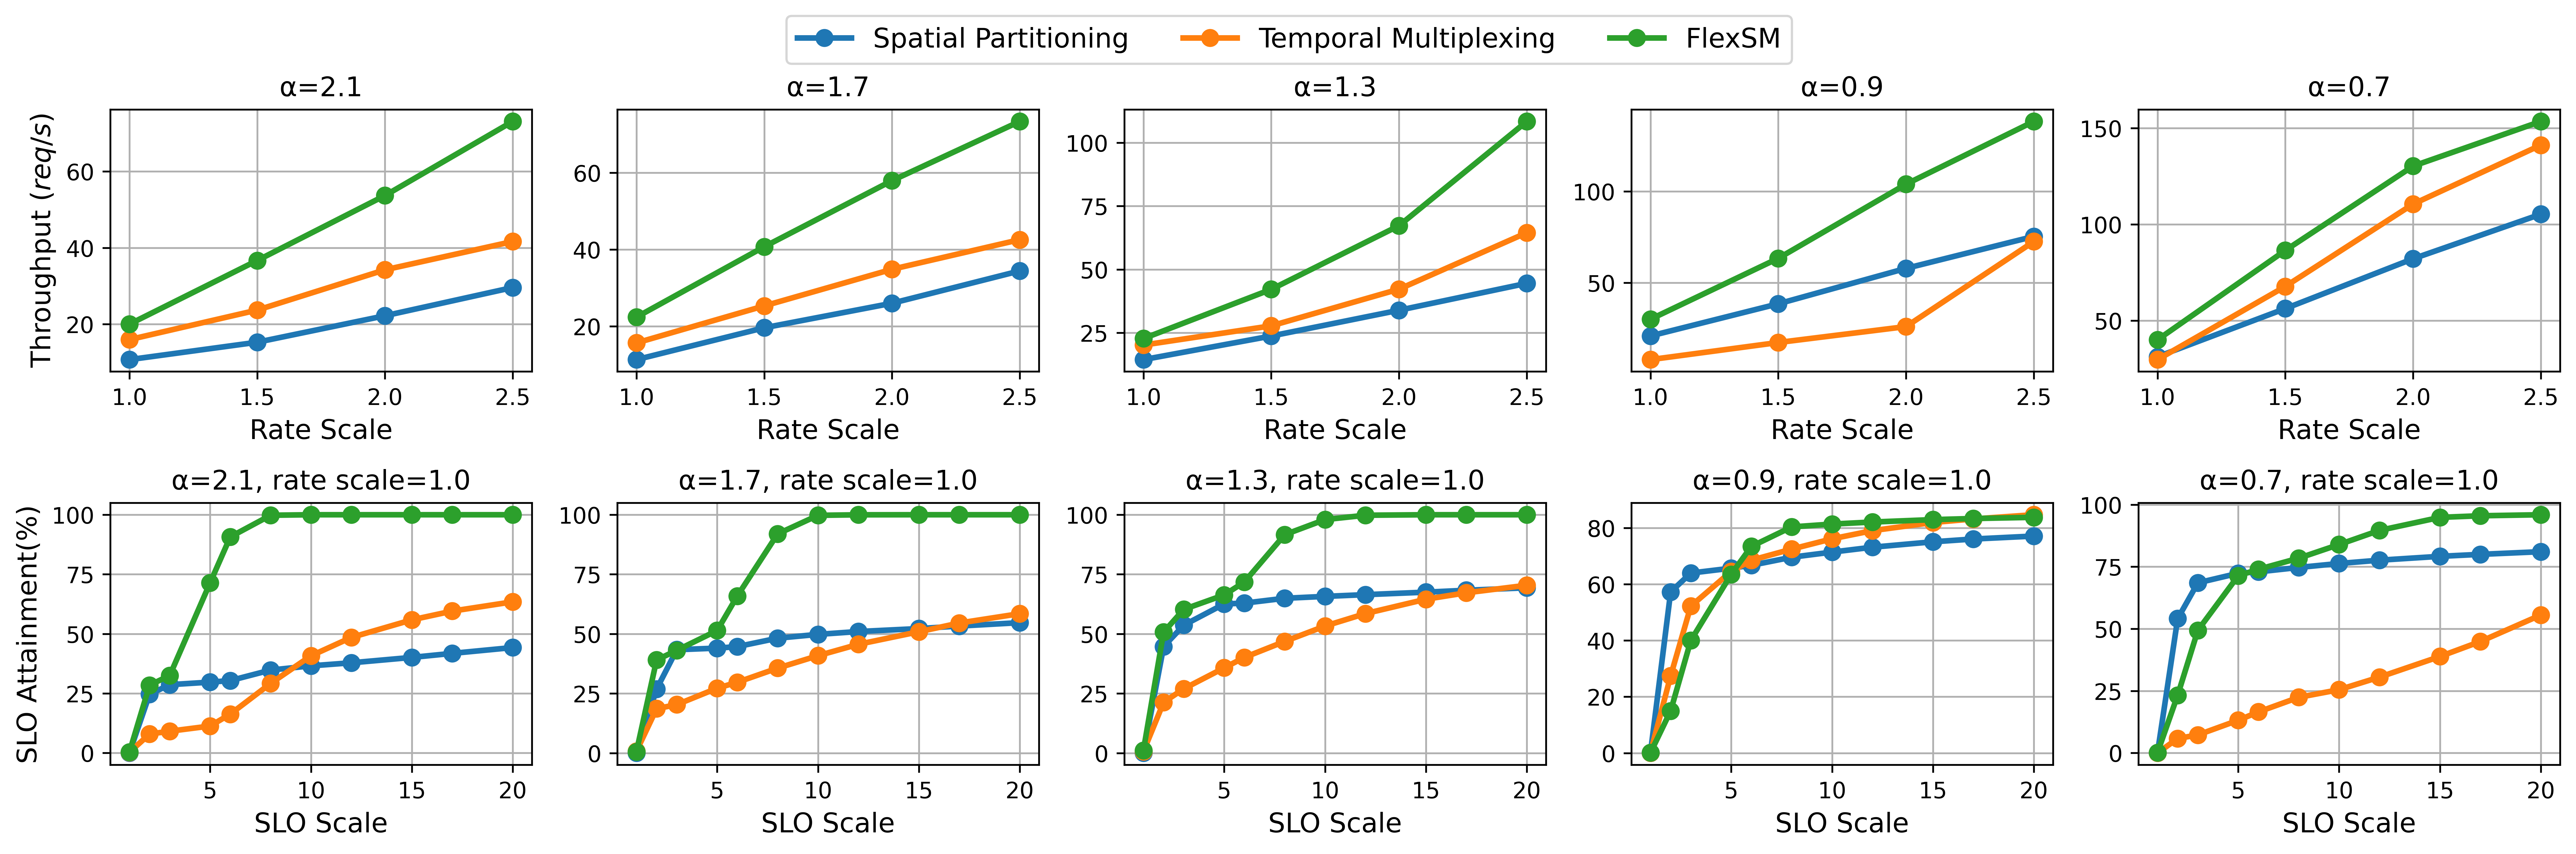

In [42]:
import matplotlib.pyplot as plt

def get_TPT(stat: dict):
    res = {}
    for (alpha, scale), records in stat.items():
        if alpha not in res:
            res[alpha] = {"spatial": {}, "muxserve": {}, "temporal": {}}

        for strategy, llm_records in records.items():
            num_models = sum(1 for _ in filter(lambda x: x.startswith("llm-"), llm_records.keys()))
            res[alpha][strategy][scale] = llm_records["weighted_tpt"] / num_models

    return res

def plot_tpt_slo(tpt_info: dict[tuple[float, float], dict[str, dict]], slo_info: dict):
    ncols = len(tpt_info)
    print(ncols)

    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 5))

    markersize=7
    linewidth=2.5
    labelsize=12

    # plot TPT
    for i, (ax, alpha) in enumerate(zip(axes[0], tpt_info)):
        title = f"α={alpha}"

        key = sorted(tpt_info[alpha]["spatial"].keys())
        # print(key)

        spatial_tpt = [tpt_info[alpha]["spatial"][k] for k in key]
        temporal_tpt = [tpt_info[alpha]["temporal"].get(k,0) for k in key]
        muxserve_tpt = [tpt_info[alpha]["muxserve"][k] for k in key]


        x_ticks = [x * 1/key[0] for x in key] # normalization
        ax.plot(x_ticks, spatial_tpt, label="Spatial Partitioning", marker="o", linewidth=linewidth, markersize=markersize)
        ax.plot(x_ticks, temporal_tpt, label="Temporal Multiplexing", marker="o", linewidth=linewidth, markersize=markersize)
        ax.plot(x_ticks, muxserve_tpt,  label="MuxServe",  marker="o", linewidth=linewidth, markersize=markersize)

        ax.grid()

        if i == 0:
            ax.set_ylabel("Throughput ($req/s$)", fontsize=labelsize)

        ax.set_title(title, fontsize=labelsize)
        ax.set_xlabel("Rate Scale", fontsize=labelsize)

    # plot SLO
    records_lis = slo_info.keys()
    for i, (ax, records) in enumerate(zip(axes[1], records_lis)):
        alpha, scale = records
        title = f"α={alpha}, rate scale={scale/0.5}"
        spatial_total = slo_info[records]["spatial"].pop("total")
        muxserve_total = slo_info[records]["muxserve"].pop("total")

        if "temporal" in slo_info[records]:
            temporal_total = slo_info[records]["temporal"].pop("total")

        key = sorted(slo_info[records]["spatial"].keys())
        # print(key)

        muxserve_slo = [slo_info[records]["muxserve"][k]/muxserve_total * 100 for k in key]
        spatial_slo = [slo_info[records]["spatial"][k]/spatial_total * 100 for k in key]
        if "temporal" in slo_info[records]:
            temporal_slo = [slo_info[records]["temporal"][k]/temporal_total * 100 for k in key]

        slice = 11
        ax.plot(key[:slice], spatial_slo[:slice], label="spatial", marker="o", linewidth=linewidth, markersize=markersize)
        if "temporal" in slo_info[records]:
            ax.plot(key[:slice], temporal_slo[:slice], label="temporal", marker="o", linewidth=linewidth, markersize=markersize)
        ax.plot(key[:slice], muxserve_slo[:slice],  label="muxserve", marker="o", linewidth=linewidth, markersize=markersize)

        if i == 0:
            print(spatial_slo[:slice])
            print(temporal_slo[:slice])
            print(muxserve_slo[:slice])

        ax.grid()
        # ax.legend()

        if i == 0:
            ax.set_ylabel("SLO Attainment(%)", fontsize=labelsize)

        ax.set_title(title, fontsize=labelsize)
        ax.set_xlabel("SLO Scale", fontsize=labelsize)


    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles,
               labels,
               loc='upper center',
               ncol=6,
               bbox_to_anchor=(0.5, 1.06),
               fontsize=labelsize)

    fig.dpi=600
    plt.tight_layout()
    fig.savefig("e2e.pdf", bbox_inches='tight', pad_inches=0.05)

tpt_info = get_TPT(res)
slo_info = get_SLO(res, 0.5)

# pprint(tpt_info)
plot_tpt_slo(tpt_info, slo_info)